# Simulation (ctobssim) 
## (no output on disk. Everything is saved in memory)

The purpose of this notebook is to perform a simulation using `ctobbsim` (and other scripts), create a count map with `ctskymap`, fit the spectrum with `cssens` and plot the spectrum using a function in the script `make_spectrum` (which comes together with ctools). 

In order to do the simulation, one has two options:
- create an *observation container* file with the [given notebook](observation_definition.ipynb), in which many different pointings can be specified and might be useful for some specific analysis;
- perform a simpler simulation, setting everything directly in this notebook.

In [1]:
import gammalib
import ctools
import cscripts

# 1) Model Creation


We need to provide a **model** for the source that we want to simulate; since many sources are simulated together, the xml model will have a section for every source to simulate, including the background. An example model is in $CTOOLS/share/models/crab.xml.

In [2]:
#!xmllint $CTOOLS/share/models/crab.xml

The simplest way to create the model of the source is by hand, editing an existing model (for example the Crab model) and adjusting the parameters to the desired value. This approach is useful for a first test, but then one need to have a way of creating XML models rapidly and in a simple way.

In order to do so, we have written a **Python** script which read in input all the data concerning the source that one wants to simulate (both the source itself and the background) and produces the XML model to be given to ctools. 

The script can bu used both with the notebook, that you find in sexten_2017/event_creator/Model_Creation.ipynb, or by running the python script from command line ($ python scriptModel_variable.py fileinput.txt). Please read the README that you find in the `model_creator` folder (you can find it on [this link](https://github.com/sharingan90/sexten_2017/blob/master/model_creator/README.md)).


# 2) Set up the simulation
## NOTE: choose just one of the following options.
The simulation can be set up in two main different ways: 
## - **WITH** *the observation definition XML* file (built with  [this](observation_definition.ipynb) notebook)...

### a) using the gammalib library

In [ ]:
obs_cont_bool = True
obsutils_bool = False

obs = gammalib.GObservations('out_csobsdef.xml')
obs.models(gammalib.GModels("crab_mem.xml"))
sim = ctools.ctobssim(obs)

sim.run()

In [ ]:
src_name = obs.models()[0].name()
ra = obs.models()[src_name]["RA"].value()
dec = obs.models()[src_name]["DEC"].value()

### b) OR using only ctools

In [ ]:
obs_cont_bool = True
obsutils_bool = False

src_model = "crab.xml"

# we extract the source name, ra and dec
models  = gammalib.GModels(gammalib.expand_env(src_model))
src_name = models[0].name()
ra      = models[0]["RA"].value()
dec     = models[0]["DEC"].value()
print(src_name, ra, dec)

In [ ]:
sim = ctools.ctobssim()
sim["inobs"] = "out_csobsdef.xml"
sim["inmodel"] = "crab_mem.xml"   #we load a sample model

sim.run()

### ...and both in case a) and b) one can also retreive the results with sim.obs()[*id_num*].events()...

In [ ]:
# ...and print the results

print(sim.obs()[0].events())   #for the first pointing (id = 0001)
#print(sim.obs()[1].events())   #for the second pointing (id = 0002)...and so on

## - WITHOUT the observation definition XML file, 

## either by:

### c) using the cscripts named csobsutil,

In [ ]:
# the variable obsutils_bool is set uqual to True since we are performing the simulation with csobsutils
obs_cont_bool = False
obsutils_bool = True

src_model = "crab_mem.xml"

models  = gammalib.GModels(gammalib.expand_env(src_model))
src_name = models[0].name()
ra      = models[0]["RA"].value()
dec     = models[0]["DEC"].value()

dur = 30        # seconds
emin = 0.05          # in TeV
emax = 20.0          # in TeV
rad = 8.0
caldb, irf = 'prod2','South_0.5h'
deadc = 0.95

pattern = cscripts.obsutils.set_obs_patterns("single", ra=ra, dec=dec, offset=1.0)   #the other option is "four"
obs = cscripts.obsutils.set_obs_list(pattern, duration=dur, emin=emin, emax=emax, rad=rad, caldb=caldb, irf=irf, deadc = deadc)
obs.models(gammalib.GModels(src_model))
sim = cscripts.obsutils.sim(obs)


### (and again the results can be displayed)

### [**NOTE**: only in this case the results must be seen with sim[0].events() and not sim.obs()[0].events() as in the other cases.]

In [ ]:
print(sim[0].events())

### d) OR using directly ctobssim.

In [4]:
dur = 1800                         # seconds
emin, emax = 0.05, 20.0          # in TeV
rad, deadc = 8.0, 0.95
caldb, irf = 'prod2','South_0.5h'

# name of the output of the simulation
src_model = "crab_mem.xml"

models  = gammalib.GModels(gammalib.expand_env(src_model))
src_name = models[0].name()
ra      = models[0]["RA"].value()
dec     = models[0]["DEC"].value()

In [5]:
obs_cont_bool = False
obsutils_bool = False

sim = ctools.ctobssim()

sim["inmodel"] = src_model
sim["ra"] = ra
sim["dec"] = dec
sim["rad"] = rad
sim["tmin"] = 0.0
sim["tmax"] = dur
sim["emin"] = emin
sim["emax"] = emax
sim["caldb"] = caldb
sim["irf"] = irf
sim.run()

### And again see the results stored in memory.

In [ ]:
print(sim.obs())

# 3) View the results
## 3.1) Create a count map with the tool ctskymap.

In [7]:
# we clone the sim object because when the skymap instance is executed, it is deleted.
# so it's better to copy it before executing anything.

if obsutils_bool == True:
    sim_cp = sim.copy()
else:
    sim_cp = sim.obs().copy()

In [8]:
name_map_out = "skymap.fits"

skymap = ctools.ctskymap(sim_cp)
skymap['emin'] = sim_cp[0].events().emin().TeV()
skymap['emax'] = sim_cp[0].events().emax().TeV()
skymap['nxpix'] = 20
skymap['nypix'] = 20
skymap['binsz'] = 0.5
skymap['coordsys'] = "CEL"
skymap['proj'] = "AIT"
skymap['xref'] = ra 
skymap['yref'] = dec 
skymap['bkgsubtract'] = "NONE" 
skymap['outmap'] = name_map_out
skymap.execute()

and we view it with ds9:

In [ ]:
!ds9 -wcs icrs -wcs skyformat degrees skymap.fits

Another option is to view it using matplotlib and the astropy library

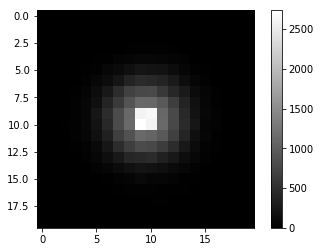

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits

hdu_list = fits.open(name_map_out)
image_data = hdu_list[0].data
plt.imshow(image_data, cmap='gray')#, interpolation = 'sinc')#, vmin=0)
plt.colorbar()
#plt.savefig("out.png")

# 4) Likelihood

In [10]:
# add description aboutn tscalc calculation
if obsutils_bool == True:
    sim_cp = sim.copy()
else:
    sim_cp = sim.obs().copy()

In [ ]:
!xmllint crab_mem.xml

In [11]:
# check whether the TS calculation has been enabled
new_models = gammalib.GModels('crab_mem.xml')
print((new_models[0].tscalc()))
#print(new_models)

True


In [12]:
like = ctools.ctlike(sim_cp)
#like['inmodel'] = 'crab_in_like.xml'
#print(like.obs()[0].events())
like.run()

In [13]:
models = like.obs().models()
for model in models:
    #print model
    if model.has_ts():
        print("Model %s has TS %.3f" % (model.name(), model.ts()))

Model Crab has TS 25254.870


# 5) Spectrum
This part is taken from the script `make_spectrum.py` which is by default installed in */usr/local/gamma/share/examples/python*.

**NOTE**: This might take some time (few minutes) since the script performs a likelihood analysis. 
### NOTE: if you use it with the observation definition xml it might take some time (3 x 30" observations takes some minutes)

In [14]:
# this is necessary due to the different output from the different tools 
if obsutils_bool == True:
    sim_spec = sim.copy()
else:
    sim_spec = sim.obs().copy()

In [15]:
spec = cscripts.csspec(sim_spec)
spec['srcname']  = src_name
spec['outfile']  = 'example_spectrum.fits'
spec['expcube']  = 'NONE'
spec['psfcube']  = 'NONE'
spec['bkgcube']  = 'NONE'
spec['edisp']    = False
spec['emin']     = sim_spec[0].events().emin().TeV()
spec['emax']     = sim_spec[0].events().emax().TeV()
spec['enumbins'] = 10
spec['ebinalg']  = 'LOG'
spec.run()
#spec.save()

spectrum = spec.spectrum()

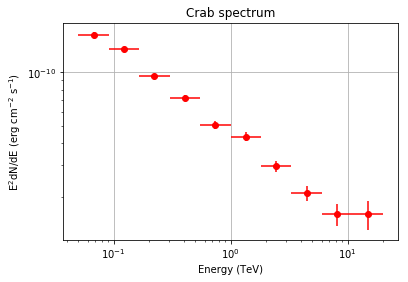

In [16]:
from make_spectrum import plot_spectrum

plot_spectrum(spectrum, "")

# 5) Butterfly Plot
#### The  input source model is the output from ctlike. If this is not the case, the option `fit` must be set equal `yes`.

In [17]:
btfy = ctools.ctbutterfly(like.obs())
# btfy['inobs'] = "Crab_out_sim.fits"
# btfy['inmodel'] = "Crab_like_out.xml"
btfy['srcname'] = src_name
# btfy['caldb'] = caldb
# btfy['irf'] = irf
btfy['outfile'] = 'butterfly_crab.txt'
btfy['emin'] = like.obs()[0].events().emin().TeV()
btfy['emax'] = like.obs()[0].events().emax().TeV()
btfy.execute()

Since the script does not display the images in terminal, we have to open a terminal window, source again `gammalib_ctools.sh` and run `$CTOOLS/share/examples/python/show_butterfly.py simulation/butterfly_crab.txt`